In [ ]:
!pip install ucimlrepo
!pip install xgboost
!pip install --upgrade xgboost

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance, plot_tree
import xgboost as xgb

##**1. Procesamiento de datos**

In [ ]:
from ucimlrepo import fetch_ucirepo

air_quality = fetch_ucirepo(id=360)
Xair = air_quality.data.features
yair = air_quality.data.targets

In [ ]:
# Crear el DataFrame con todas las características
df_total= air_quality.data.features

#Seleccionar las columnas específicas con las que se va a trabajar
df = df_total[['Date', 'Time', 'C6H6(GT)', 'T', 'RH']]

In [ ]:
# Cambiar el nombre de la variable C6H6(GT)
df = df.rename(columns={'C6H6(GT)': 'C6H6'})

In [ ]:
 #Crear columna Datetime combinada
df['Datetime'] = df['Date'] + ' ' + df['Time']

# Intentar convertir a datetime y capturar el error
# En lugar de poner format='%d/%m/%Y %H:%M:%S' poner dayfirst=False para que infiera automaticamente el formato
try:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)
except ValueError as e:
    print(f"Error al convertir fechas: {e}")

# Mostrars las filas que no se convirtieron correctamente
print(df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()])

# Mostrar las filas que no se convirtieron correctamente para asegurarnos que se convirtió buen
invalid_dates = df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()]
print("Filas con fechas no válidas:")
print(invalid_dates)

Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []
Filas con fechas no válidas:
Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []


In [ ]:
# Establecer la columna datetime como índice, eliminar las columnas Date y Time
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [ ]:
# Reemplazar los valores -200 en la columna T con NaN
df['C6H6'] = df['C6H6'].replace(-200, pd.NA)
df['T'] = df['T'].replace(-200, pd.NA)
df['RH'] = df['RH'].replace(-200, pd.NA)

# Aplicar forward fill para reemplazar los valores NaN
df['C6H6'].ffill(inplace=True)
df['T'].ffill(inplace=True)
df['RH'].ffill(inplace=True)

In [ ]:
#Sólo la columna C6H6
df = df[['C6H6']]
print(df)

                     C6H6
Datetime                 
2004-03-10 18:00:00  11.9
2004-03-10 19:00:00   9.4
2004-03-10 20:00:00   9.0
2004-03-10 21:00:00   9.2
2004-03-10 22:00:00   6.5
...                   ...
2005-04-04 10:00:00  13.5
2005-04-04 11:00:00  11.4
2005-04-04 12:00:00  12.4
2005-04-04 13:00:00   9.5
2005-04-04 14:00:00  11.9

[9357 rows x 1 columns]


##**2. Modelo ensamble XGBoost**


**Separación train y test**

In [ ]:
# Train/Test  90% y 10% se toma esta división para después poder usar el mismo % en las 5 grupos de cross validation
df_C6H6_train = df['C6H6'].iloc[:round(len(df['C6H6'])*.9)]
df_C6H6_test = df['C6H6'].iloc[round(len(df['C6H6'])*.9):]
print(len(df_C6H6_train), len(df_C6H6_test))

8421 936


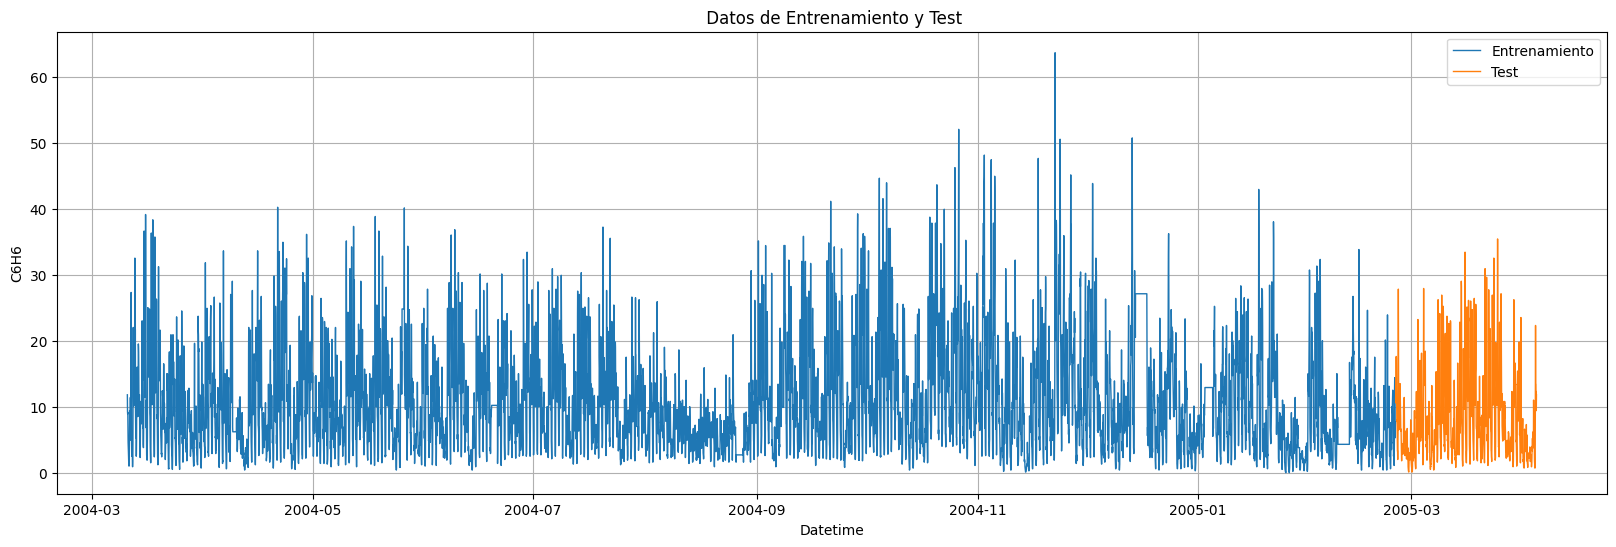

In [ ]:
# Gráficos train y test
plt.figure(figsize=(20, 6))

plt.plot(df_C6H6_train, label='Entrenamiento', linestyle='-', linewidth=1)
plt.plot(df_C6H6_test, label='Test', linestyle='-', linewidth=1)

plt.title(' Datos de Entrenamiento y Test')
plt.xlabel('Datetime')
plt.ylabel('C6H6')

plt.legend()
plt.grid(True)
plt.show()

**Cross Validation**

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
#Se usa la función TimeSeriesSplit para la separación de los datos para el cross validatio
tss = TimeSeriesSplit(n_splits=5, test_size=936, gap=24) #Se deja un gap de24 hs entre cada unos de los 5 grupos de datos
df = df.sort_index() # ordena las filas del DataFrame df según los valores del índice

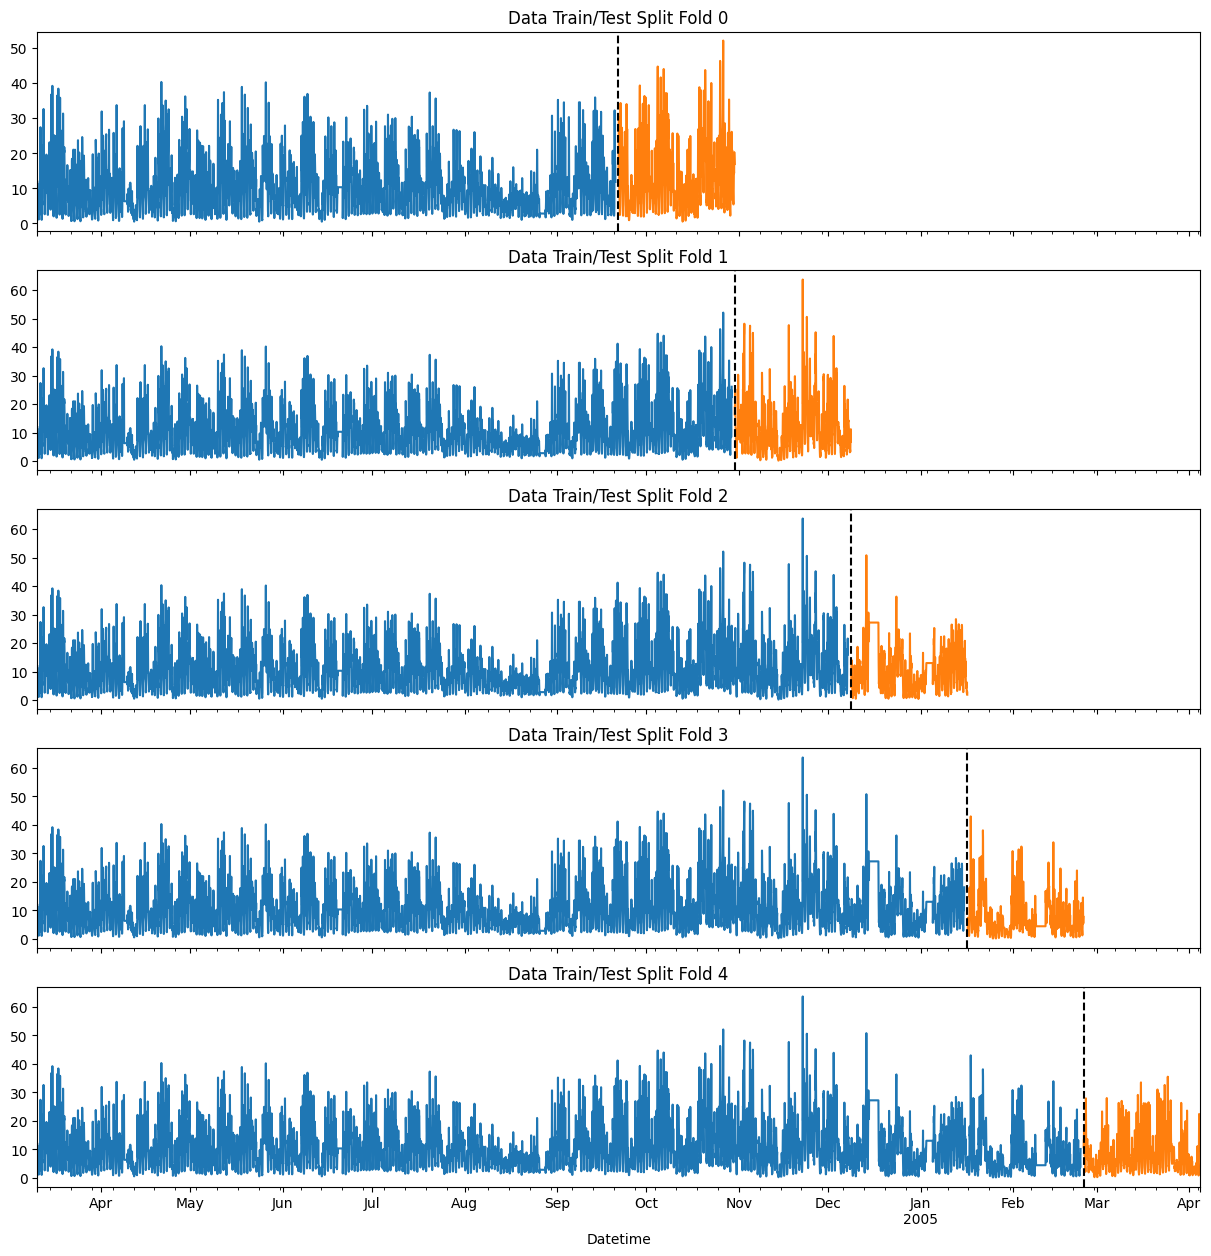

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df['C6H6']):
    train = df['C6H6'].iloc[train_idx]
    val = df['C6H6'].iloc[val_idx]
    train.plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    val.plot(ax=axs[fold],label='Val Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
#Cross validation manteniendo el orden temporal de los datos

for i, (train_index, test_index) in enumerate(tss.split(df)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[   0    1    2 ... 4650 4651 4652]
  Test:  index=[4677 4678 4679 4680 4681 4682 4683 4684 4685 4686 4687 4688 4689 4690
 4691 4692 4693 4694 4695 4696 4697 4698 4699 4700 4701 4702 4703 4704
 4705 4706 4707 4708 4709 4710 4711 4712 4713 4714 4715 4716 4717 4718
 4719 4720 4721 4722 4723 4724 4725 4726 4727 4728 4729 4730 4731 4732
 4733 4734 4735 4736 4737 4738 4739 4740 4741 4742 4743 4744 4745 4746
 4747 4748 4749 4750 4751 4752 4753 4754 4755 4756 4757 4758 4759 4760
 4761 4762 4763 4764 4765 4766 4767 4768 4769 4770 4771 4772 4773 4774
 4775 4776 4777 4778 4779 4780 4781 4782 4783 4784 4785 4786 4787 4788
 4789 4790 4791 4792 4793 4794 4795 4796 4797 4798 4799 4800 4801 4802
 4803 4804 4805 4806 4807 4808 4809 4810 4811 4812 4813 4814 4815 4816
 4817 4818 4819 4820 4821 4822 4823 4824 4825 4826 4827 4828 4829 4830
 4831 4832 4833 4834 4835 4836 4837 4838 4839 4840 4841 4842 4843 4844
 4845 4846 4847 4848 4849 4850 4851 4852 4853 4854 4855 4856 4857 4858
 48

**Creación de variables y lags**

In [ ]:
#Creación de features basadas en el índice tiempo para captar las estacionalidades

def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour #almacena en una columna nueva la hora
    df['dayofweek'] = df.index.dayofweek #almacena en una columna nueva el día de la semana
    df['quarter'] = df.index.quarter #trimestre
    df['month'] = df.index.month #mes
    df['year'] = df.index.year #año
    df['dayofyear'] = df.index.dayofyear #dia del año: de 1 a 365
    df['dayofmonth'] = df.index.day #día del mes: de 1 a 31
    df['weekofyear'] = df.index.isocalendar().week #día de la semana 1 a 52
    return df

In [ ]:
df = create_features(df)
print(df.head(5))

                     C6H6  hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                      
2004-03-10 18:00:00  11.9    18          2        1      3  2004         70   
2004-03-10 19:00:00   9.4    19          2        1      3  2004         70   
2004-03-10 20:00:00   9.0    20          2        1      3  2004         70   
2004-03-10 21:00:00   9.2    21          2        1      3  2004         70   
2004-03-10 22:00:00   6.5    22          2        1      3  2004         70   

                     dayofmonth  weekofyear  
Datetime                                     
2004-03-10 18:00:00          10          11  
2004-03-10 19:00:00          10          11  
2004-03-10 20:00:00          10          11  
2004-03-10 21:00:00          10          11  
2004-03-10 22:00:00          10          11  


In [ ]:
#Agregado de lags ayuda a captar la estacionaliad
def add_lags(df):
    df['lag_24'] = df['C6H6'].shift(24) #estacionalidad de 1 día
    df['lag_168'] = df['C6H6'].shift(168) #estacionaliad de 1 semana
    df['lag_720'] = df['C6H6'].shift(720) #estacionalidad de 1 mes
    return df

# Aplicar la función al DataFrame
df = add_lags(df)
print(df.tail(5))


                     C6H6  hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                      
2005-04-04 10:00:00  13.5    10          0        2      4  2005         94   
2005-04-04 11:00:00  11.4    11          0        2      4  2005         94   
2005-04-04 12:00:00  12.4    12          0        2      4  2005         94   
2005-04-04 13:00:00   9.5    13          0        2      4  2005         94   
2005-04-04 14:00:00  11.9    14          0        2      4  2005         94   

                     dayofmonth  weekofyear  lag_24  lag_168  lag_720  
Datetime                                                               
2005-04-04 10:00:00           4          14     3.4      5.2      3.1  
2005-04-04 11:00:00           4          14     5.3      5.5      5.2  
2005-04-04 12:00:00           4          14     5.3      4.2      5.3  
2005-04-04 13:00:00           4          14     3.8      3.3      6.7  
2005-04-04 14:

**Entrenamiento**

In [ ]:
df = df.sort_index()

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=936, gap=24)

In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):   #se usa cross validation
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag_24','lag_168','lag_720']
    TARGET = 'C6H6'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #modelado basado en árboles
                           n_estimators=1000, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:squarederror', #Para hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01)

    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)   # Muestra información de entrenamiento cada 100 iteraciones

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

[0]	validation_0-rmse:6.63147	validation_1-rmse:9.75198
[100]	validation_0-rmse:4.82508	validation_1-rmse:7.29889
[200]	validation_0-rmse:4.31887	validation_1-rmse:6.57896
[300]	validation_0-rmse:4.10878	validation_1-rmse:6.37342
[400]	validation_0-rmse:3.97907	validation_1-rmse:6.23268
[500]	validation_0-rmse:3.88086	validation_1-rmse:6.15479
[600]	validation_0-rmse:3.80683	validation_1-rmse:6.00504
[700]	validation_0-rmse:3.74700	validation_1-rmse:5.89820
[800]	validation_0-rmse:3.69461	validation_1-rmse:5.83109
[900]	validation_0-rmse:3.63461	validation_1-rmse:5.81197
[999]	validation_0-rmse:3.56364	validation_1-rmse:5.81401
[0]	validation_0-rmse:7.26052	validation_1-rmse:9.60371
[100]	validation_0-rmse:5.20902	validation_1-rmse:7.75777
[200]	validation_0-rmse:4.63570	validation_1-rmse:7.32349
[300]	validation_0-rmse:4.40817	validation_1-rmse:7.25410
[400]	validation_0-rmse:4.26563	validation_1-rmse:7.21293
[500]	validation_0-rmse:4.14157	validation_1-rmse:7.11654
[600]	validation_0

In [ ]:
#promedio de la puntuacion en cada folds
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 5.8950
Fold scores:[5.814014947747946, 7.1641556558242545, 6.625243898151061, 6.054985558124985, 3.816497414782628]


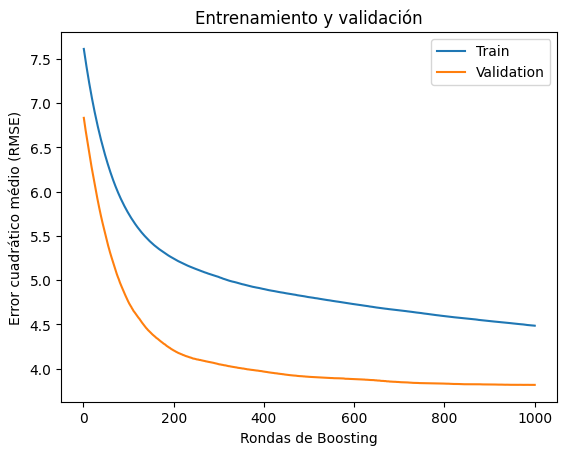

In [ ]:
# Curva train y validacion según la métrica RMSE
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Rondas de Boosting')
plt.ylabel('Error cuadrático médio (RMSE)')
plt.title('Entrenamiento y validación')
plt.legend()
plt.show()

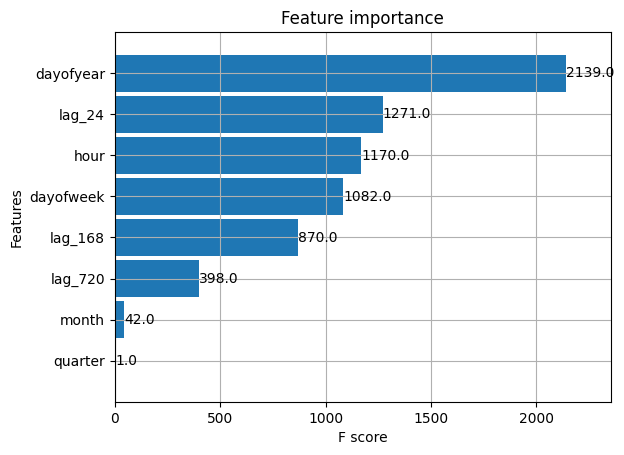

In [ ]:
#Importancia de las variables
_ = plot_importance(reg, height=0.9)

In [ ]:
y_pred = reg.predict(X_val)
y_pred

array([ 8.628345 ,  8.137298 , 10.222354 , 12.394771 , 12.589086 ,
       12.471324 , 11.016571 ,  8.796843 ,  5.845467 ,  4.6794305,
        3.4760902,  3.1487474,  2.4058497,  2.3487535,  2.3487535,
        3.1036215,  4.8218164, 12.298867 , 13.2404   ,  8.906644 ,
        7.435867 ,  6.2679467,  8.02749  ,  8.383311 ,  9.924508 ,
       11.507802 , 11.919224 , 14.520621 , 15.090151 , 14.875925 ,
       11.472768 ,  8.030746 ,  8.319368 ,  7.16986  ,  6.799321 ,
        4.159946 ,  2.8541677,  2.9464114,  2.3911197,  3.2660608,
        4.908226 ,  9.051997 , 10.549441 ,  8.077455 ,  7.993288 ,
        6.7542815,  6.402309 ,  6.402309 ,  6.0181212,  6.402309 ,
        7.0140557,  9.406683 ,  9.424648 ,  9.751271 ,  7.770119 ,
        8.462066 ,  8.025647 ,  7.2547727,  6.399173 ,  6.1211543,
        5.1183405,  3.8980193,  1.9964119,  1.9758798,  2.3124537,
        3.428161 ,  3.7087326,  3.427004 ,  3.3339548,  3.5551217,
        3.9739017,  4.087336 ,  3.4673345,  3.4768844,  4.5630

In [ ]:
val['prediction'] = reg.predict(X_val)
val['prediction']


<ipython-input-193-45d02612bb7c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


,prediction
Datetime,
2005-02-24 15:00:00,8.628345
2005-02-24 16:00:00,8.137298
2005-02-24 17:00:00,10.222354
2005-02-24 18:00:00,12.394771
2005-02-24 19:00:00,12.589086
...,...
2005-04-04 10:00:00,8.444319
2005-04-04 11:00:00,9.309025
2005-04-04 12:00:00,8.582692


In [ ]:
val

,C6H6,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_24,lag_168,lag_720,prediction
Datetime,,,,,,,,,,,,,
2005-02-24 15:00:00,10.7,15,3,1,2,2005,55,24,8,9.9,4.8,3.6,8.628345
2005-02-24 16:00:00,13.3,16,3,1,2,2005,55,24,8,9.2,5.0,3.6,8.137298
2005-02-24 17:00:00,13.2,17,3,1,2,2005,55,24,8,10.3,5.2,3.9,10.222354
2005-02-24 18:00:00,17.5,18,3,1,2,2005,55,24,8,11.4,10.0,4.9,12.394771
2005-02-24 19:00:00,17.7,19,3,1,2,2005,55,24,8,11.7,11.1,5.8,12.589086
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,13.5,10,0,2,4,2005,94,4,14,3.4,5.2,3.1,8.444319
2005-04-04 11:00:00,11.4,11,0,2,4,2005,94,4,14,5.3,5.5,5.2,9.309025
2005-04-04 12:00:00,12.4,12,0,2,4,2005,94,4,14,5.3,4.2,5.3,8.582692


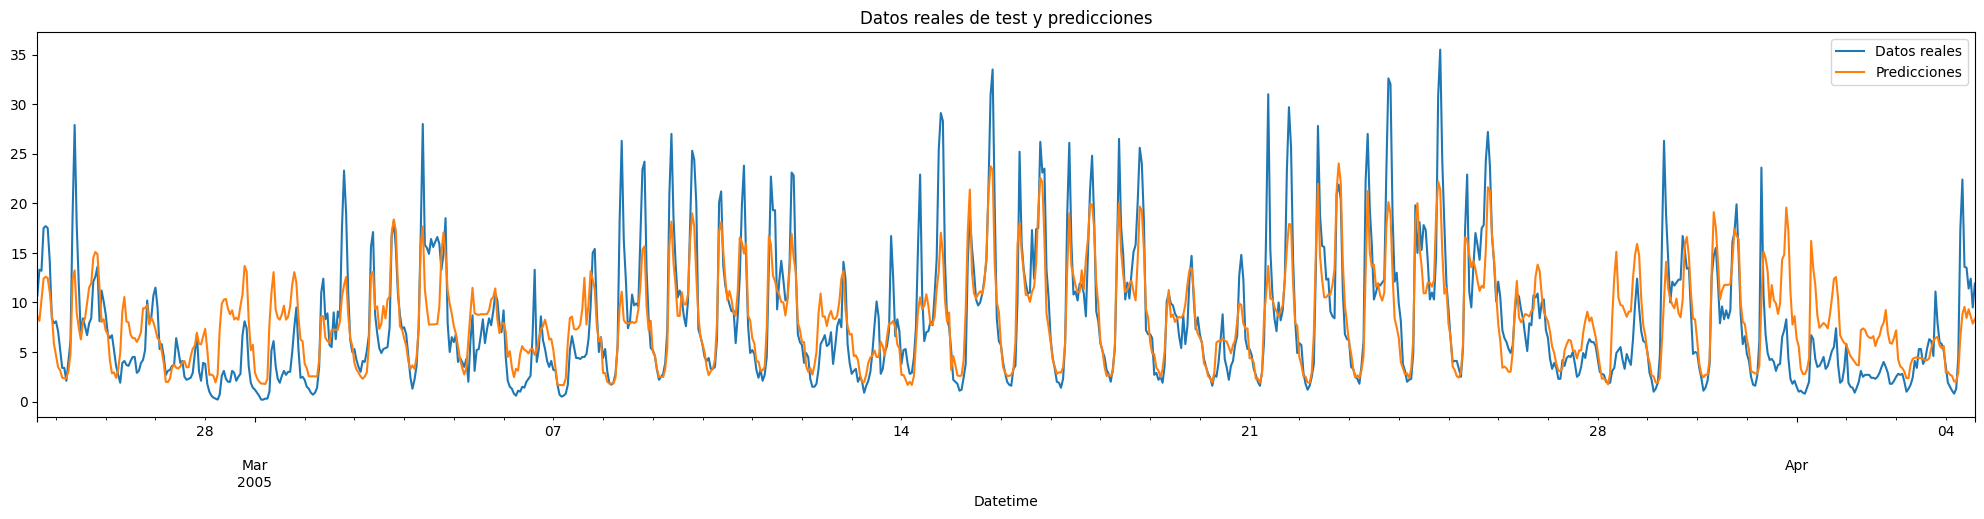

In [ ]:
#Gráfica
ax = val.loc[(val.index >= '2005-02-24 15:00:00')]['C6H6'].plot(figsize=(25, 5), title='Datos reales de test y predicciones')
val.loc[(val.index >= '2005-02-24 15:00:00')]['prediction'].plot()
plt.legend(['Datos reales','Predicciones'])
plt.show()


In [ ]:
# Métriccas
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
score = np.sqrt(mean_squared_error(y_val, y_pred))

# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 14.56565251704248
Mean Absolute Error (MAE): 2.7711279499225125
Root Mean Squared Error (RMSE): 3.816497414782628
RMSE Score on Test set: 3.82


**Modelo con menos n_estimators**

Por la grafica vemos que la curva de train sigue bajando miestras la curva de test se mantiene horizontal. Se aplica early stopping para evitar sobre ajuste.

In [ ]:
pip install --upgrade xgboost


In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):   #se usa cross validation
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag_24','lag_168','lag_720']
    TARGET = 'C6H6'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #modelado basado en árboles
                           n_estimators=300, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:squarederror', #Para hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01)


    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)


[0]	validation_0-rmse:6.63147	validation_1-rmse:9.75198
[100]	validation_0-rmse:4.82508	validation_1-rmse:7.29889
[200]	validation_0-rmse:4.31887	validation_1-rmse:6.57896
[299]	validation_0-rmse:4.10987	validation_1-rmse:6.37589
[0]	validation_0-rmse:7.26052	validation_1-rmse:9.60371
[100]	validation_0-rmse:5.20902	validation_1-rmse:7.75777
[200]	validation_0-rmse:4.63570	validation_1-rmse:7.32349
[299]	validation_0-rmse:4.40976	validation_1-rmse:7.25333
[0]	validation_0-rmse:7.63933	validation_1-rmse:7.92728
[100]	validation_0-rmse:5.62768	validation_1-rmse:6.56785
[200]	validation_0-rmse:5.08052	validation_1-rmse:6.31305
[299]	validation_0-rmse:4.85954	validation_1-rmse:6.31788
[0]	validation_0-rmse:7.67077	validation_1-rmse:7.21853
[100]	validation_0-rmse:5.71213	validation_1-rmse:6.00036
[200]	validation_0-rmse:5.18020	validation_1-rmse:5.80191
[299]	validation_0-rmse:4.96364	validation_1-rmse:5.78390
[0]	validation_0-rmse:7.61373	validation_1-rmse:6.83470
[100]	validation_0-rmse:

In [ ]:
#promedio de la puntuacion en cada folds
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 5.9562
Fold scores:[6.375893153863648, 7.25333402535676, 6.317881378794478, 5.783899904116701, 4.050112299471819]


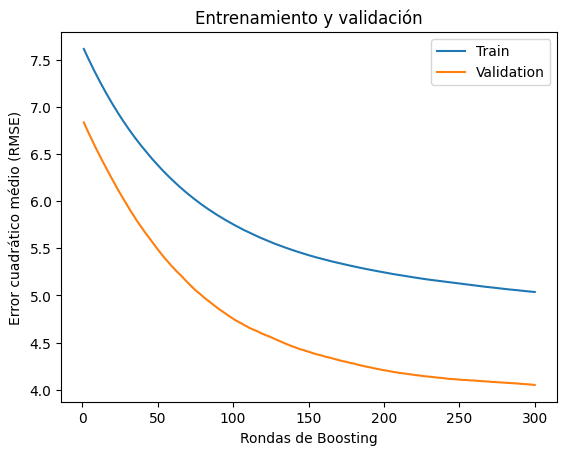

In [ ]:
# Curva train y validacion según la métrica RMSE
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Rondas de Boosting')
plt.ylabel('Error cuadrático médio (RMSE)')
plt.title('Entrenamiento y validación')
plt.legend()
plt.show()

In [ ]:
# Métriccas
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
score = np.sqrt(mean_squared_error(y_val, y_pred))

# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 16.403409638332906
Mean Absolute Error (MAE): 3.0453937105134004
Root Mean Squared Error (RMSE): 4.050112299471819
RMSE Score on Test set: 4.05


**Otros Modelos probados**


In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):   #se usa cross validation
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    FEATURES = ['dayofyear','hour', 'dayofweek', 'month',
                'lag_24','lag_168','lag_720']
    TARGET = 'C6H6'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #modelado basado en árboles
                           n_estimators=1000, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:squarederror', #Para hacer regresión
                           max_depth=10, #Máxima profundidad de un arbol.
                           learning_rate=0.01)

    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)   # Muestra información de entrenamiento cada 100 iteraciones

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

[0]	validation_0-rmse:6.61458	validation_1-rmse:9.76015
[100]	validation_0-rmse:3.50528	validation_1-rmse:7.93326
[200]	validation_0-rmse:2.19502	validation_1-rmse:7.27297
[300]	validation_0-rmse:1.59422	validation_1-rmse:7.08806
[400]	validation_0-rmse:1.28823	validation_1-rmse:7.00789
[500]	validation_0-rmse:1.07353	validation_1-rmse:6.95874
[600]	validation_0-rmse:0.91324	validation_1-rmse:6.94485
[700]	validation_0-rmse:0.79363	validation_1-rmse:6.95808
[800]	validation_0-rmse:0.67377	validation_1-rmse:6.97938
[900]	validation_0-rmse:0.58337	validation_1-rmse:6.96384
[999]	validation_0-rmse:0.50128	validation_1-rmse:6.95768
[0]	validation_0-rmse:7.24372	validation_1-rmse:9.60595
[100]	validation_0-rmse:3.84915	validation_1-rmse:7.77656
[200]	validation_0-rmse:2.49537	validation_1-rmse:7.52469
[300]	validation_0-rmse:1.81696	validation_1-rmse:7.50097
[400]	validation_0-rmse:1.46647	validation_1-rmse:7.49356
[500]	validation_0-rmse:1.23699	validation_1-rmse:7.49678
[600]	validation_0

In [ ]:
#promedio de la puntuacion en cada folds
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 6.4618
Fold scores:[6.957677369049011, 7.54394205220235, 7.363157288937258, 6.135488303894283, 4.308759401684959]


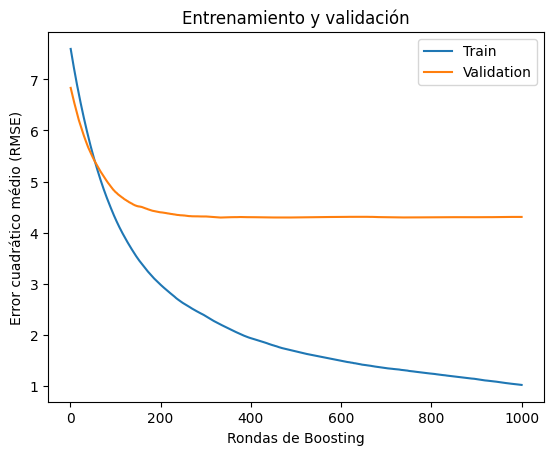

In [ ]:
# Curva train y validacion según la métrica RMSE
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Rondas de Boosting')
plt.ylabel('Error cuadrático médio (RMSE)')
plt.title('Entrenamiento y validación')
plt.legend()
plt.show()

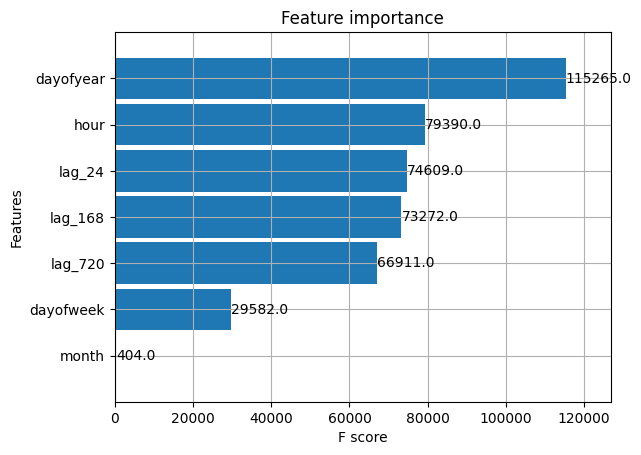

In [ ]:
#Importancia de las variables
_ = plot_importance(reg, height=0.9)

In [ ]:
y_pred = reg.predict(X_val)
val['prediction'] = reg.predict(X_val)

<ipython-input-108-50150a14ecd9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


In [ ]:
# Métriccas
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
score = np.sqrt(mean_squared_error(y_val, y_pred))

# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 18.56540758160853
Mean Absolute Error (MAE): 3.0159973777002755
Root Mean Squared Error (RMSE): 4.308759401684959
RMSE Score on Test set: 4.31


##**3. Con variables exogenas T y RH**

Se levanta de nuevo el dataset (paso 1)


In [ ]:
print (df)

                     C6H6     T    RH
Datetime                             
2004-03-10 18:00:00  11.9  13.6  48.9
2004-03-10 19:00:00   9.4  13.3  47.7
2004-03-10 20:00:00   9.0  11.9  54.0
2004-03-10 21:00:00   9.2  11.0  60.0
2004-03-10 22:00:00   6.5  11.2  59.6
...                   ...   ...   ...
2005-04-04 10:00:00  13.5  21.9  29.3
2005-04-04 11:00:00  11.4  24.3  23.7
2005-04-04 12:00:00  12.4  26.9  18.3
2005-04-04 13:00:00   9.5  28.3  13.5
2005-04-04 14:00:00  11.9  28.5  13.1

[9357 rows x 3 columns]


In [ ]:
#Se usa la función TimeSeriesSplit para la separación de los datos para el cross validatio
tss = TimeSeriesSplit(n_splits=5, test_size=936, gap=24) #Se deja un gap de24 hs entre cada unos de los 5 grupos de datos
df = df.sort_index() # ordena las filas del DataFrame df según los valores del índice

In [ ]:
#Cross validation manteniendo el orden temporal de los datos

for i, (train_index, test_index) in enumerate(tss.split(df)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[   0    1    2 ... 4650 4651 4652]
  Test:  index=[4677 4678 4679 4680 4681 4682 4683 4684 4685 4686 4687 4688 4689 4690
 4691 4692 4693 4694 4695 4696 4697 4698 4699 4700 4701 4702 4703 4704
 4705 4706 4707 4708 4709 4710 4711 4712 4713 4714 4715 4716 4717 4718
 4719 4720 4721 4722 4723 4724 4725 4726 4727 4728 4729 4730 4731 4732
 4733 4734 4735 4736 4737 4738 4739 4740 4741 4742 4743 4744 4745 4746
 4747 4748 4749 4750 4751 4752 4753 4754 4755 4756 4757 4758 4759 4760
 4761 4762 4763 4764 4765 4766 4767 4768 4769 4770 4771 4772 4773 4774
 4775 4776 4777 4778 4779 4780 4781 4782 4783 4784 4785 4786 4787 4788
 4789 4790 4791 4792 4793 4794 4795 4796 4797 4798 4799 4800 4801 4802
 4803 4804 4805 4806 4807 4808 4809 4810 4811 4812 4813 4814 4815 4816
 4817 4818 4819 4820 4821 4822 4823 4824 4825 4826 4827 4828 4829 4830
 4831 4832 4833 4834 4835 4836 4837 4838 4839 4840 4841 4842 4843 4844
 4845 4846 4847 4848 4849 4850 4851 4852 4853 4854 4855 4856 4857 4858
 48

In [ ]:
#Creación de features basadas en el índice tiempo para captar las estacionalidades

def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour #almacena en una columna nueva la hora
    df['dayofweek'] = df.index.dayofweek #almacena en una columna nueva el día de la semana
    df['quarter'] = df.index.quarter #trimestre
    df['month'] = df.index.month #mes
    df['year'] = df.index.year #año
    df['dayofyear'] = df.index.dayofyear #dia del año: de 1 a 365
    df['dayofmonth'] = df.index.day #día del mes: de 1 a 31
    df['weekofyear'] = df.index.isocalendar().week #día de la semana 1 a 52
    return df

In [ ]:
df = create_features(df)
print(df.head(5))

                     C6H6     T    RH  hour  dayofweek  quarter  month  year  \
Datetime                                                                       
2004-03-10 18:00:00  11.9  13.6  48.9    18          2        1      3  2004   
2004-03-10 19:00:00   9.4  13.3  47.7    19          2        1      3  2004   
2004-03-10 20:00:00   9.0  11.9  54.0    20          2        1      3  2004   
2004-03-10 21:00:00   9.2  11.0  60.0    21          2        1      3  2004   
2004-03-10 22:00:00   6.5  11.2  59.6    22          2        1      3  2004   

                     dayofyear  dayofmonth  weekofyear  
Datetime                                                
2004-03-10 18:00:00         70          10          11  
2004-03-10 19:00:00         70          10          11  
2004-03-10 20:00:00         70          10          11  
2004-03-10 21:00:00         70          10          11  
2004-03-10 22:00:00         70          10          11  


In [ ]:
#Agregado de lags ayuda a captar la estacionaliad
def add_lags(df):
    df['lag_24'] = df['C6H6'].shift(24) #estacionalidad de 1 día
    df['lag_168'] = df['C6H6'].shift(168) #estacionaliad de 1 semana
    df['lag_720'] = df['C6H6'].shift(720) #estacionalidad de 1 mes
    return df

# Aplicar la función al DataFrame
df = add_lags(df)
print(df.tail(5))

                     C6H6     T    RH  hour  dayofweek  quarter  month  year  \
Datetime                                                                       
2005-04-04 10:00:00  13.5  21.9  29.3    10          0        2      4  2005   
2005-04-04 11:00:00  11.4  24.3  23.7    11          0        2      4  2005   
2005-04-04 12:00:00  12.4  26.9  18.3    12          0        2      4  2005   
2005-04-04 13:00:00   9.5  28.3  13.5    13          0        2      4  2005   
2005-04-04 14:00:00  11.9  28.5  13.1    14          0        2      4  2005   

                     dayofyear  dayofmonth  weekofyear  lag_24  lag_168  \
Datetime                                                                  
2005-04-04 10:00:00         94           4          14     3.4      5.2   
2005-04-04 11:00:00         94           4          14     5.3      5.5   
2005-04-04 12:00:00         94           4          14     5.3      4.2   
2005-04-04 13:00:00         94           4          14     3.8  

In [ ]:
df = df.sort_index()

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=936, gap=24)

In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year','T','RH',
                'lag_24','lag_168','lag_720'] #se agrega T y RH como variables exogenas
    TARGET = 'C6H6'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree',
                           n_estimators=1000,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)

    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

[0]	validation_0-rmse:6.63142	validation_1-rmse:9.75208
[100]	validation_0-rmse:4.79788	validation_1-rmse:7.30408
[200]	validation_0-rmse:4.25952	validation_1-rmse:6.56565
[300]	validation_0-rmse:4.03107	validation_1-rmse:6.34183
[400]	validation_0-rmse:3.88297	validation_1-rmse:6.15103
[500]	validation_0-rmse:3.77106	validation_1-rmse:6.06056
[600]	validation_0-rmse:3.68134	validation_1-rmse:6.01268
[700]	validation_0-rmse:3.60556	validation_1-rmse:5.95144
[800]	validation_0-rmse:3.52786	validation_1-rmse:5.94047
[900]	validation_0-rmse:3.46460	validation_1-rmse:5.92755
[999]	validation_0-rmse:3.40608	validation_1-rmse:5.92639
[0]	validation_0-rmse:7.26052	validation_1-rmse:9.60371
[100]	validation_0-rmse:5.19736	validation_1-rmse:7.77781
[200]	validation_0-rmse:4.60113	validation_1-rmse:7.33032
[300]	validation_0-rmse:4.34657	validation_1-rmse:7.21365
[400]	validation_0-rmse:4.18112	validation_1-rmse:7.14879
[500]	validation_0-rmse:4.04641	validation_1-rmse:7.11743
[600]	validation_0

In [ ]:
#promedio de la puntuacion en cada folds
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 5.8236
Fold scores:[5.926387176555467, 7.310285386234656, 6.408664349795854, 5.6805361206067495, 3.7922977895620895]


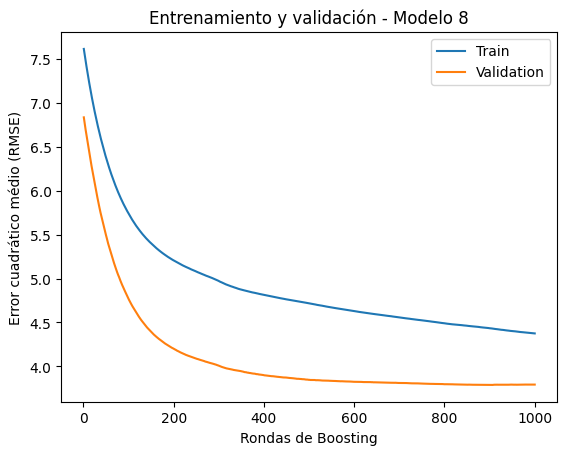

In [ ]:
# Curva train y validacion según la métrica RMSE
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Rondas de Boosting')
plt.ylabel('Error cuadrático médio (RMSE)')
plt.title('Entrenamiento y validación - Modelo 8')
plt.legend()
plt.show()

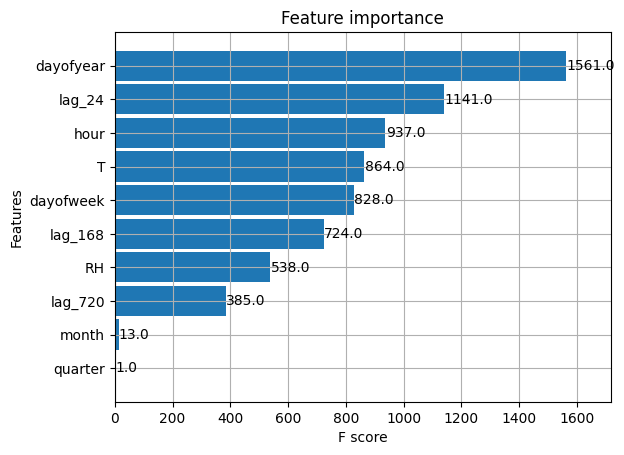

In [ ]:
#Importancia de las variables
_ = plot_importance(reg, height=0.9)

In [ ]:
# Métriccas
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
score = np.sqrt(mean_squared_error(y_val, y_pred))

# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 14.38152252471751
Mean Absolute Error (MAE): 2.730705587705995
Root Mean Squared Error (RMSE): 3.7922977895620895
RMSE Score on Test set: 3.79


In [ ]:
val['prediction'] = reg.predict(X_val)
val

<ipython-input-231-703062ed108f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


,C6H6,T,RH,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_24,lag_168,lag_720,prediction
Datetime,,,,,,,,,,,,,,,
2005-02-24 15:00:00,10.7,8.5,66.3,15,3,1,2,2005,55,24,8,9.9,4.8,3.6,9.884499
2005-02-24 16:00:00,13.3,7.6,70.8,16,3,1,2,2005,55,24,8,9.2,5.0,3.6,9.343939
2005-02-24 17:00:00,13.2,7.2,72.4,17,3,1,2,2005,55,24,8,10.3,5.2,3.9,10.751668
2005-02-24 18:00:00,17.5,6.7,74.2,18,3,1,2,2005,55,24,8,11.4,10.0,4.9,12.864853
2005-02-24 19:00:00,17.7,6.1,75.8,19,3,1,2,2005,55,24,8,11.7,11.1,5.8,12.949862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,13.5,21.9,29.3,10,0,2,4,2005,94,4,14,3.4,5.2,3.1,8.618924
2005-04-04 11:00:00,11.4,24.3,23.7,11,0,2,4,2005,94,4,14,5.3,5.5,5.2,9.774436
2005-04-04 12:00:00,12.4,26.9,18.3,12,0,2,4,2005,94,4,14,5.3,4.2,5.3,8.873939


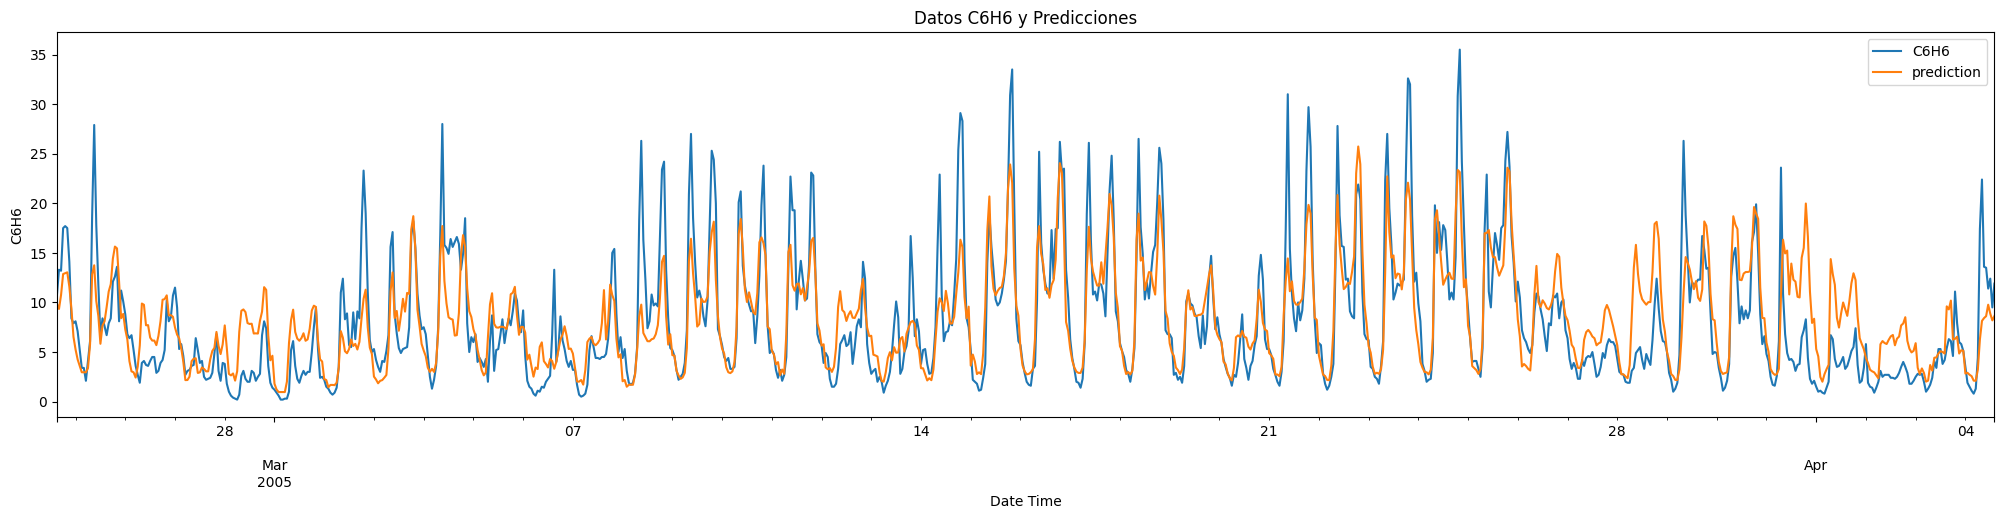

In [ ]:
#Gráfica
ax = val.loc[(val.index >= '2005-02-24 15:00:00')]['C6H6'].plot(figsize=(25, 5), title='Datos reales de test y predicciones')
val.loc[(val.index >= '2005-02-24 15:00:00')]['prediction'].plot()
plt.legend(['Datos reales','Predicciones'])

plt.title('Datos C6H6 y Predicciones')
plt.legend()

plt.xlabel('Date Time')
plt.ylabel('C6H6')

plt.show()


In [ ]:
val['prediction'] = reg.predict(X_val )
val


<ipython-input-248-0912667ba041>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val )


,C6H6,T,RH,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_24,lag_168,lag_720,prediction
Datetime,,,,,,,,,,,,,,,
2005-02-24 15:00:00,10.7,8.5,66.3,15,3,1,2,2005,55,24,8,9.9,4.8,3.6,9.884499
2005-02-24 16:00:00,13.3,7.6,70.8,16,3,1,2,2005,55,24,8,9.2,5.0,3.6,9.343939
2005-02-24 17:00:00,13.2,7.2,72.4,17,3,1,2,2005,55,24,8,10.3,5.2,3.9,10.751668
2005-02-24 18:00:00,17.5,6.7,74.2,18,3,1,2,2005,55,24,8,11.4,10.0,4.9,12.864853
2005-02-24 19:00:00,17.7,6.1,75.8,19,3,1,2,2005,55,24,8,11.7,11.1,5.8,12.949862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,13.5,21.9,29.3,10,0,2,4,2005,94,4,14,3.4,5.2,3.1,8.618924
2005-04-04 11:00:00,11.4,24.3,23.7,11,0,2,4,2005,94,4,14,5.3,5.5,5.2,9.774436
2005-04-04 12:00:00,12.4,26.9,18.3,12,0,2,4,2005,94,4,14,5.3,4.2,5.3,8.873939


from matplotlib import pyplot as plt
val['C6H6'].plot(kind='hist', bins=20, title='C6H6')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
val['T'].plot(kind='hist', bins=20, title='T')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
val['RH'].plot(kind='hist', bins=20, title='RH')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
val['hour'].plot(kind='hist', bins=20, title='hour')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
val.plot(kind='scatter', x='C6H6', y='T', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
val.plot(kind='scatter', x='T', y='RH', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
val.plot(kind='scatter', x='RH', y='hour', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
val.plot(kind='scatter', x='hour', y='dayofweek', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['T']
  ys = series['C6H6']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = val.sort_values('T', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('T')
_ = plt.ylabel('C6H6')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['T']
  ys = series['RH']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = val.sort_values('T', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('T')
_ = plt.ylabel('RH')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['T']
  ys = series['hour']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = val.sort_values('T', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('T')
_ = plt.ylabel('hour')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['T']
  ys = series['dayofweek']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = val.sort_values('T', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('T')
_ = plt.ylabel('dayofweek')

from matplotlib import pyplot as plt
val['C6H6'].plot(kind='line', figsize=(8, 4), title='C6H6')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
val['T'].plot(kind='line', figsize=(8, 4), title='T')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
val['RH'].plot(kind='line', figsize=(8, 4), title='RH')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
val['hour'].plot(kind='line', figsize=(8, 4), title='hour')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
train['prediction'] = reg.predict(X_train)
train

<ipython-input-250-588bb2489198>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['prediction'] = reg.predict(X_train)


,C6H6,T,RH,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_24,lag_168,lag_720,prediction
Datetime,,,,,,,,,,,,,,,
2004-03-10 18:00:00,11.9,13.6,48.9,18,2,1,3,2004,70,10,11,NaN,NaN,NaN,9.083370
2004-03-10 19:00:00,9.4,13.3,47.7,19,2,1,3,2004,70,10,11,NaN,NaN,NaN,8.614573
2004-03-10 20:00:00,9.0,11.9,54.0,20,2,1,3,2004,70,10,11,NaN,NaN,NaN,9.171714
2004-03-10 21:00:00,9.2,11.0,60.0,21,2,1,3,2004,70,10,11,NaN,NaN,NaN,8.199978
2004-03-10 22:00:00,6.5,11.2,59.6,22,2,1,3,2004,70,10,11,NaN,NaN,NaN,7.132957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-02-23 10:00:00,3.8,3.1,83.0,10,2,1,2,2005,54,23,8,15.0,9.0,5.7,12.055283
2005-02-23 11:00:00,3.6,2.8,83.9,11,2,1,2,2005,54,23,8,6.9,5.0,5.4,7.341877
2005-02-23 12:00:00,3.7,3.9,79.5,12,2,1,2,2005,54,23,8,9.1,4.3,5.1,8.114326


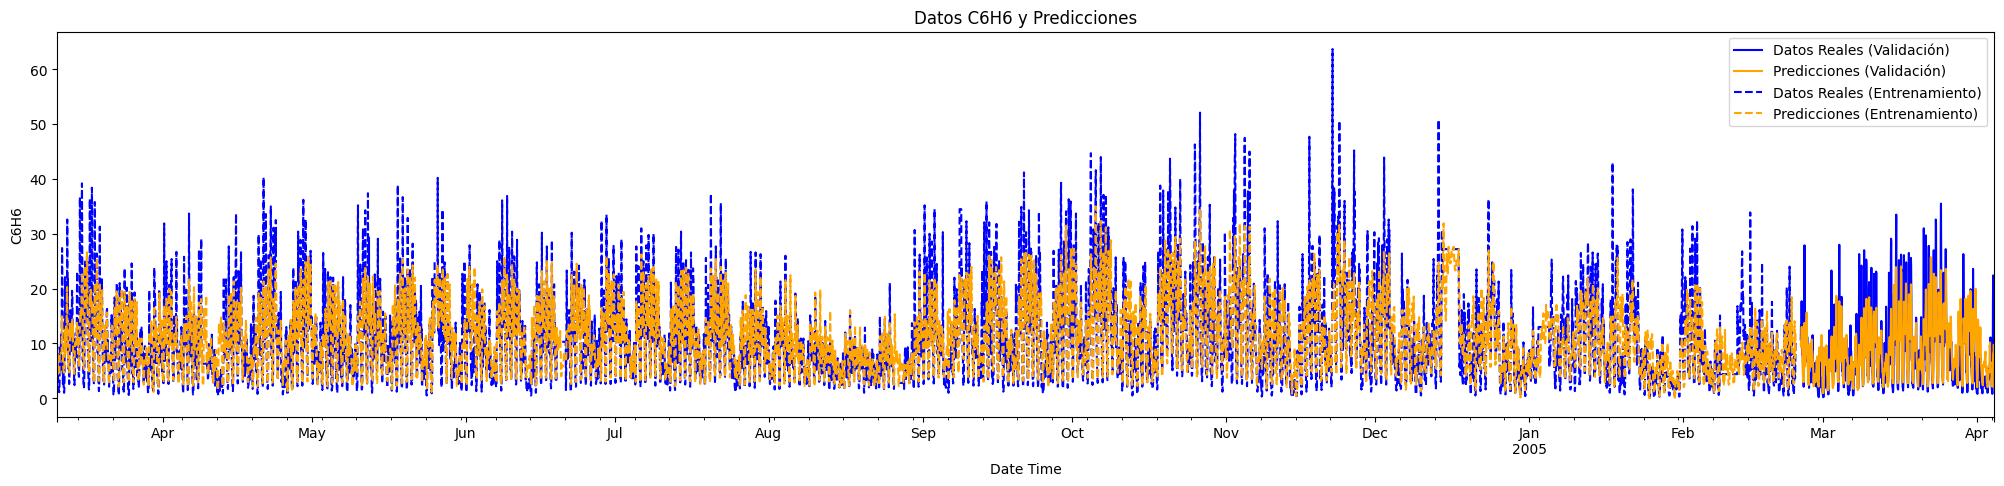

In [ ]:
plt.figure(figsize=(25, 5))

# Graficar los datos reales y las predicciones para el DataFrame de validación
ax = val.loc[val.index >= '2005-02-24 15:00:00']['C6H6'].plot(label='Datos Reales (Validación)', color='blue')
val.loc[val.index >= '2005-02-24 15:00:00']['prediction'].plot(ax=ax, label='Predicciones (Validación)', color='orange')

# Graficar los datos reales y las predicciones para el DataFrame de entrenamiento
train.loc[train.index >= '2004-03-10 18:00:00']['C6H6'].plot(ax=ax, label='Datos Reales (Entrenamiento)', color='blue', linestyle='--')
train.loc[train.index >= '2004-03-10 18:00:00']['prediction'].plot(ax=ax, label='Predicciones (Entrenamiento)', color='orange', linestyle='--')

plt.title('Datos C6H6 y Predicciones')
plt.legend()

plt.xlabel('Date Time')
plt.ylabel('C6H6')

plt.show()

**Predicciones futuras próximas 24 horas**

In [ ]:
# Último índice en tus datos
last_index = pd.Timestamp('2005-04-04 14:00:00')

In [ ]:
# Data frame vacio con el index para los datos futuros
future_dates = pd.date_range(start=last_index + pd.Timedelta(hours=1), periods=24, freq='H')

In [ ]:
future_df = pd.DataFrame(index=future_dates)

In [ ]:
T_futuro = df['T'].mean()
print(T_futuro)

18.31735599016779


In [ ]:
RH_futuro = df['RH'].mean()
print(RH_futuro)

48.817430800470234


In [ ]:
#Agregar variables al data frame futuro de 24 horas, simular los lags futuros y estimar un valor  futuro para las variables exógenas

future_df['year'] = future_df.index.year
future_df['month'] = future_df.index.month
future_df['dayofweek'] = future_df.index.dayofweek
future_df['dayofyear'] = future_df.index.dayofyear
future_df['hour'] = future_df.index.hour
future_df['quarter'] = future_df.index.quarter
future_df['dayofmonth'] = future_df.index.day
future_df['weekofyear'] = future_df.index.isocalendar().week

future_df['T'] = 18  # Asignar un valor para T (promedio de los valores reales de T)
future_df['RH'] = 48 # Asignar un valor para RH (promedio de los valores reales de RH)
future_df['lag_24'] = future_df['T']  # Simular valores para lag_24
future_df['lag_168'] = future_df['T']  # Simular valores para lag_168
future_df['lag_720'] = future_df['T']  # Simular valores para lag_720

In [ ]:
# Ordenar las columnas para que coincidan con las que espera el modelo
feature_columns = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'T', 'RH', 'lag_24', 'lag_168', 'lag_720']
future_df = future_df[feature_columns]

In [ ]:
future_predictions = reg.predict(future_df)


In [ ]:
future_predictions = reg.predict(future_df)
future_df['prediction'] = future_predictions
future_df


<ipython-input-281-7e82837f8811>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_df['prediction'] = future_predictions


,dayofyear,hour,dayofweek,quarter,month,year,T,RH,lag_24,lag_168,lag_720,prediction
2005-04-04 15:00:00,94,15,0,2,4,2005,18,48,18,18,18,18.689507
2005-04-04 16:00:00,94,16,0,2,4,2005,18,48,18,18,18,18.689507
2005-04-04 17:00:00,94,17,0,2,4,2005,18,48,18,18,18,19.587740
2005-04-04 18:00:00,94,18,0,2,4,2005,18,48,18,18,18,20.190353
2005-04-04 19:00:00,94,19,0,2,4,2005,18,48,18,18,18,20.190353
2005-04-04 20:00:00,94,20,0,2,4,2005,18,48,18,18,18,19.877634
2005-04-04 21:00:00,94,21,0,2,4,2005,18,48,18,18,18,16.895599
2005-04-04 22:00:00,94,22,0,2,4,2005,18,48,18,18,18,15.417351
2005-04-04 23:00:00,94,23,0,2,4,2005,18,48,18,18,18,15.417351
2005-04-05 00:00:00,95,0,1,2,4,2005,18,48,18,18,18,14.324089


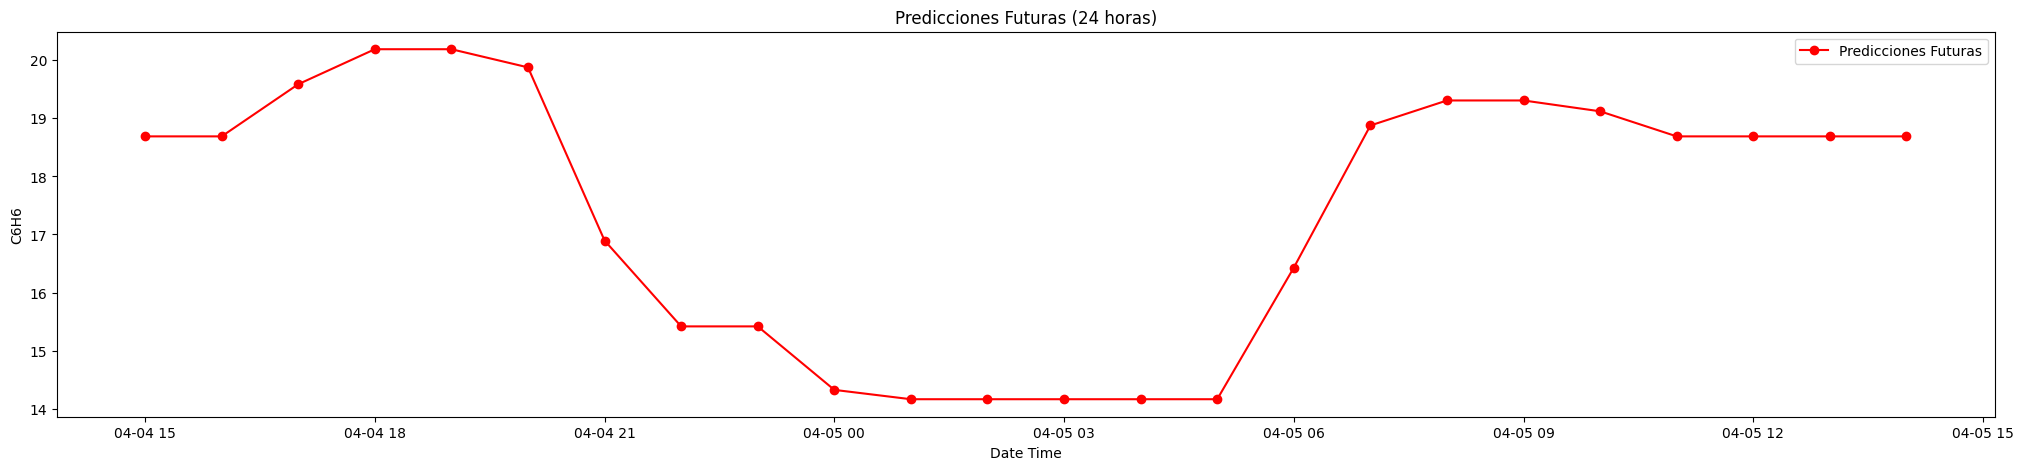

In [ ]:
plt.figure(figsize=(25, 5))

# Graficar predicciones futuras
plt.plot(future_df.index, future_df['prediction'], label='Predicciones Futuras',  color='red', marker='o')

plt.title('Predicciones Futuras (24 horas)')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('C6H6')

# Mostrar el gráfico
plt.show()

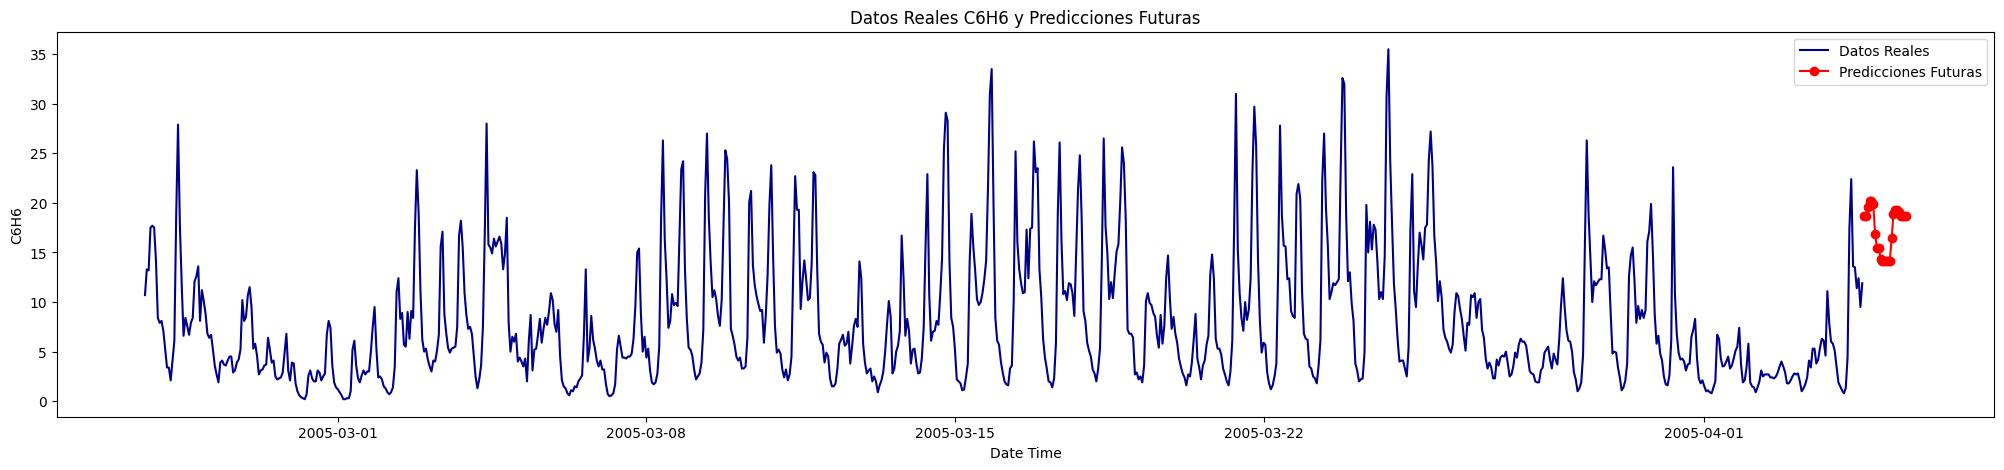

In [ ]:
plt.figure(figsize=(25, 5))

plt.plot(val.index, val['C6H6'], label='Datos Reales', color='darkblue')

# Predicciones futuras
plt.plot(future_df.index, future_df['prediction'], label='Predicciones Futuras',  color='red', marker='o')

# Configurar título y leyenda
plt.title('Datos Reales C6H6 y Predicciones Futuras')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('C6H6')

# Mostrar el gráfico
plt.show()